In [25]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
from scipy.integrate import quad
import pandas as pd
import random
from pyvbmc import VBMC
from V_A_step_jump_fit_utils import PDF_hit_V_A_change, CDF_hit_V_A_change, rho_A_t_fn, cum_A_t_fn


# data

In [12]:
# read out_LED.csv as dataframe
og_df = pd.read_csv('../out_LED.csv')

# chose non repeat trials - 0 or 2 or missing
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]

# only session type 7
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]

# training level 16
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

# find ABL and ILD
ABL_arr = df['ABL'].unique()
ILD_arr = df['ILD'].unique()


# sort ILD arr in ascending order
ILD_arr = np.sort(ILD_arr)
ABL_arr = np.sort(ABL_arr)

print('ABL:', ABL_arr)
print('ILD:', ILD_arr)

ABL: [20 40 60]
ILD: [-16.  -8.  -4.  -2.  -1.   1.   2.   4.   8.  16.]


In [13]:
df_to_fit = df[ df['LED_trial'] == 1 ] 

# VBMC

In [14]:
T_trunc = 0.3

In [ ]:


def compute_loglike(row, base_V_A, new_V_A, theta_A, t_A_aff):
    rt = row['timed_fix']
    t_stim = row['intended_fix']
    t_led = row['intended_fix'] - row['LED_onset_time']

    
    if rt < T_trunc:
        likelihood = 0
    else:
        if t_led == 0: # only new V_A will be used
            pdf_trunc_factor = 1 - cum_A_t_fn(T_trunc - t_A_aff, new_V_A, theta_A)
            if rt < t_stim:
                likelihood =  rho_A_t_fn(rt - t_A_aff, new_V_A, theta_A) / pdf_trunc_factor
            elif rt > t_stim:
                likelihood = ( 1 - cum_A_t_fn(t_stim - t_A_aff, new_V_A, theta_A) ) / pdf_trunc_factor
        else: # V_A change in middle
            trunc_factor = 1 - CDF_hit_V_A_change(T_trunc - t_A_aff, base_V_A, new_V_A, theta_A, t_led)
            if rt < t_stim:
                likelihood = PDF_hit_V_A_change(rt-t_A_aff, base_V_A, new_V_A, theta_A, t_led) / trunc_factor
            elif rt > t_stim:
                likelihood = ( 1 - CDF_hit_V_A_change(t_stim - t_A_aff, base_V_A, new_V_A, theta_A, t_led) ) / trunc_factor

    if likelihood <= 0:
        likelihood = 1e-50

    
    return np.log(likelihood)    



def psiam_tied_loglike_fn(params):
    base_V_A, new_V_A, theta_A, t_A_aff = params

    all_loglike = Parallel(n_jobs=-1)(delayed(compute_loglike)(row, base_V_A, new_V_A, theta_A, t_A_aff)\
                                      for _, row in df_to_fit.iterrows() \
                                        if (not np.isnan(row['timed_fix'] + row['intended_fix'] + row['LED_onset_time']))) 
                                   

    loglike = np.sum(all_loglike)
    return loglike

# bounds

In [6]:
base_V_A_bounds = [0.1, 5]
new_V_A_bounds = [0.1, 5]
theta_A_bounds = [0.1, 5]
t_A_aff_bounds = [-5, 0.1]

base_V_A_plausible_bounds = [0.5, 3]
new_V_A_plausible_bounds = [0.5, 3]
theta_A_plausible_bounds = [0.5, 3]
t_A_aff_plausible_bounds = [-2, 0.06]

# prior

In [7]:
def trapezoidal_logpdf(x, a, b, c, d):
    if x < a or x > d:
        return -np.inf  # Logarithm of zero
    area = ((b - a) + (d - c)) / 2 + (c - b)
    h_max = 1.0 / area  # Height of the trapezoid to normalize the area to 1
    
    if a <= x <= b:
        pdf_value = ((x - a) / (b - a)) * h_max
    elif b < x < c:
        pdf_value = h_max
    elif c <= x <= d:
        pdf_value = ((d - x) / (d - c)) * h_max
    else:
        pdf_value = 0.0  # This case is redundant due to the initial check

    if pdf_value <= 0.0:
        return -np.inf
    else:
        return np.log(pdf_value)
    

def vbmc_prior_abort_fn(params):
    base_V_A, new_V_A, theta_A, t_A_aff = params

    base_V_A_logpdf = trapezoidal_logpdf(base_V_A, base_V_A_bounds[0], base_V_A_plausible_bounds[0], base_V_A_plausible_bounds[1], base_V_A_bounds[1])
    new_V_A_logpdf = trapezoidal_logpdf(new_V_A, new_V_A_bounds[0], new_V_A_plausible_bounds[0], new_V_A_plausible_bounds[1], new_V_A_bounds[1])
    theta_A_logpdf = trapezoidal_logpdf(theta_A, theta_A_bounds[0], theta_A_plausible_bounds[0], theta_A_plausible_bounds[1], theta_A_bounds[1])
    t_A_aff_logpdf = trapezoidal_logpdf(t_A_aff, t_A_aff_bounds[0], t_A_aff_plausible_bounds[0], t_A_aff_plausible_bounds[1], t_A_aff_bounds[1])
    return base_V_A_logpdf + new_V_A_logpdf + theta_A_logpdf + t_A_aff_logpdf

# joint

In [8]:
def vbmc_joint(params):
    return vbmc_prior_abort_fn(params) + psiam_tied_loglike_fn(params)

# run vbmc

In [9]:
lb = [base_V_A_bounds[0], new_V_A_bounds[0], theta_A_bounds[0], t_A_aff_bounds[0]]
ub = [base_V_A_bounds[1], new_V_A_bounds[1], theta_A_bounds[1], t_A_aff_bounds[1]]

plb = [base_V_A_plausible_bounds[0], new_V_A_plausible_bounds[0], theta_A_plausible_bounds[0], t_A_aff_plausible_bounds[0]]
pub = [base_V_A_plausible_bounds[1], new_V_A_plausible_bounds[1], theta_A_plausible_bounds[1], t_A_aff_plausible_bounds[1]]

np.random.seed(42)
base_V_A_0 = np.random.uniform(base_V_A_plausible_bounds[0], base_V_A_plausible_bounds[1])
new_V_A_0 = np.random.uniform(new_V_A_plausible_bounds[0], new_V_A_plausible_bounds[1])
theta_A_0 = np.random.uniform(theta_A_plausible_bounds[0], theta_A_plausible_bounds[1])
t_A_aff_0 = np.random.uniform(t_A_aff_plausible_bounds[0], t_A_aff_plausible_bounds[1])

x_0 = np.array([base_V_A_0, new_V_A_0, theta_A_0, t_A_aff_0])

In [10]:
vbmc = VBMC(vbmc_joint, x_0, lb, ub, plb, pub, options={'display': 'off'})
vp, results = vbmc.optimize()

Reshaping x0 to row vector.
Reshaping lower bounds to (1, 4).
Reshaping upper bounds to (1, 4).
Reshaping plausible lower bounds to (1, 4).
Reshaping plausible upper bounds to (1, 4).
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -153978.179 +/-0.047.


In [13]:
# save vbmc
vp.save('V_A_step_jump_LED_on_vbmc.pkl')

In [26]:
import pickle
with open('V_A_step_jump_LED_on_vbmc.pkl', 'rb') as f:
    vp = pickle.load(f)

# corner plot

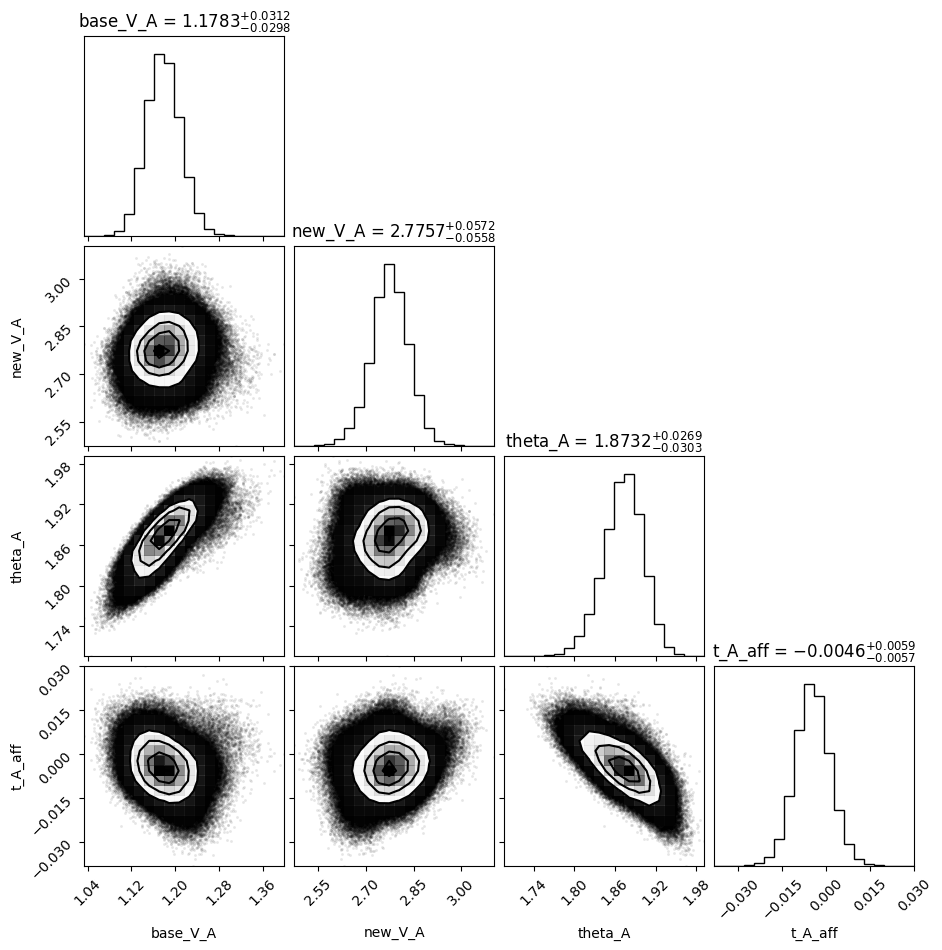

In [27]:
import corner
vp_samples = vp.sample(int(1e6))[0]
base_V_A_samp = vp_samples[:,0]
new_V_A_samp = vp_samples[:,1]
theta_A_samp = vp_samples[:,2]
t_A_aff_samp = vp_samples[:,3]

combined_samples = np.transpose(np.vstack((base_V_A_samp, new_V_A_samp, theta_A_samp, t_A_aff_samp)))
param_labels = ['base_V_A', 'new_V_A', 'theta_A', 't_A_aff']
corner.corner (combined_samples, labels=param_labels, show_titles=True, title_fmt=".4f");


# fit and see

In [28]:
# data
data_abort_rt = df_to_fit[ (df_to_fit['timed_fix'] < df_to_fit['intended_fix']) & \
                            (df_to_fit['timed_fix'] > T_trunc) ]['timed_fix'].values

bin_width = 0.05
bins = np.arange(0, np.max(data_abort_rt), bin_width)
t_pts = bins[:-1] + bin_width / 2


In [65]:
len(data_abort_rt)/len(df_to_fit)

0.1515062454077884

In [29]:
LED_times = (df_to_fit['intended_fix'] - df_to_fit['LED_onset_time']).unique()

# remove zero
LED_times = LED_times[ LED_times != 0 ]

In [30]:
base_V_A_mean = np.mean(base_V_A_samp)
new_V_A_mean = np.mean(new_V_A_samp)
theta_A_mean = np.mean(theta_A_samp)
t_A_aff_mean = np.mean(t_A_aff_samp)

In [51]:
N_theory = 1000
unique_pairs = list(zip(df_to_fit['intended_fix'], df_to_fit['intended_fix'] - df_to_fit['LED_onset_time']))
sampled_pairs = random.sample(unique_pairs, min(N_theory, len(unique_pairs)))  # Ensure no more than the available pairs are sampled

In [77]:
def calc_trunc_pdf(t, base_V_A, new_V_A, theta_A, t_A_aff, t_led, trunc_factor):   
    # pdf
    if t <= T_trunc:
        pdf = 0
    else:
        pdf = PDF_hit_V_A_change(t - t_A_aff, base_V_A, new_V_A, theta_A, t_led) / trunc_factor
    return pdf

def calc_trunc_cdf(base_V_A, new_V_A, theta_A, t_A_aff, t_led, t_stim, trunc_factor):
    # cdf
    if t_stim  <= T_trunc:
        cdf = 0
    else:
        cdf = (CDF_hit_V_A_change(t_stim - t_A_aff, base_V_A, new_V_A, theta_A, t_led)) / trunc_factor

    return cdf


In [78]:
from tqdm import tqdm
pdf_ensemble = np.zeros((N_theory, len(t_pts)))
cdf_ensemble = np.zeros((N_theory, ))
for i, (t_stim, t_led) in tqdm(enumerate (sampled_pairs), total=N_theory):
    if t_stim <= t_led:
        print('Issue')
        break
    
    trunc_factor = 1 - CDF_hit_V_A_change(T_trunc - t_A_aff_mean, base_V_A_mean, new_V_A_mean, theta_A_mean, t_led)
    pdf_ensemble[i,:] = [calc_trunc_pdf(t, base_V_A_mean, new_V_A_mean, theta_A_mean, t_A_aff_mean, t_led, trunc_factor) for t in t_pts]
    cdf_ensemble[i] = calc_trunc_cdf(base_V_A_mean, new_V_A_mean, theta_A_mean, t_A_aff_mean, t_led, t_stim, trunc_factor)    


  1%|▏         | 14/1000 [00:00<00:26, 36.84it/s]/home/rka/code/ddm_data/fitting_aborts/V_A_step_jump_fit_utils.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  return (1/np.sqrt(2 * (np.pi) * t)) * \
/home/rka/code/ddm_data/fitting_aborts/V_A_step_jump_fit_utils.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  ( np.exp(-((x - v*t)**2)/(2*t)) - np.exp( 2*v*a - ((x - 2*a - v*t)**2)/(2*t) ) )
/home/rka/code/ddm_data/fitting_aborts/V_A_step_jump_fit_utils.py:19: RuntimeWarning: invalid value encountered in scalar multiply
  return (1/np.sqrt(2 * (np.pi) * t)) * \
/home/rka/code/ddm_data/fitting_aborts/V_A_step_jump_fit_utils.py:40: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  p = quad(P_old_at_x_times_P_new_hit, -np.inf, a, args=(t, V_A_old, V_A_new, a, t_LED))[0]
100%|██████████| 1000/1000 [00:29<00:00, 33.83it/s]


In [79]:
pdf_ensemble_mean = np.nanmean(pdf_ensemble, axis=0)
cdf_ensemble_mean = np.nanmean(cdf_ensemble)

In [80]:
cdf_ensemble_mean

0.18910847358429073

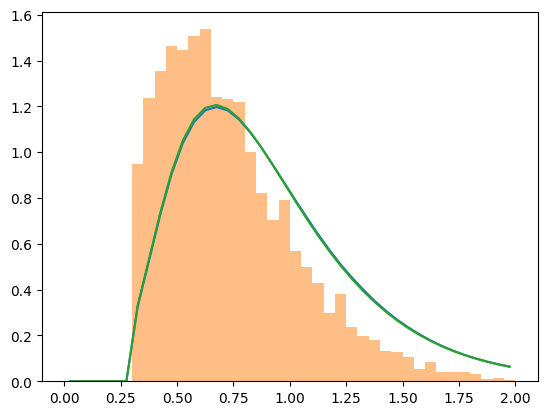

In [59]:
plt.plot(t_pts, pdf_ensemble_mean, label='Ensemble mean')
plt.hist(data_abort_rt, bins=bins, density=True, alpha=0.5)
plt.plot(t_pts, pdf_vs_led_mean);